In [144]:
import os
import pandas as pd

# Obtener la lista de nombres de archivo
filenames = os.listdir('./dataset_fake_real')

# Crear listas para los nombres de archivo y las categorías
categories = []

# Determinar la categoría de cada archivo
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'fake':
        categories.append('fake')
    else:
        categories.append('real')

# Crear el DataFrame completo
fake_real = pd.DataFrame({'filename': filenames, 'category': categories})

# Filtrar 100 imágenes de cada categoría
fake_sample = fake_real[fake_real['category'] == 'fake'].sample(n=4000, random_state=42)
real_sample = fake_real[fake_real['category'] == 'real'].sample(n=4000, random_state=42)

# Unir los dos subconjuntos
sample_df = pd.concat([fake_sample, real_sample]).reset_index(drop=True)

# Mostrar el DataFrame resultante
display(sample_df)


,filename,category
0,fake_3667.png,fake
1,fake_5380.png,fake
2,fake_22212.png,fake
3,fake_4830.png,fake
4,fake_19839.png,fake
...,...,...
7995,real_3150.png,real
7996,real_15657.png,real
7997,real_11083.png,real
7998,real_21076.png,real


In [145]:
#ahora metamoslo a una red neuronal

from sklearn.model_selection import train_test_split

#Extracción de DataFrames de entrenamiento y prueba
train_df, test_df = train_test_split(sample_df, test_size = 0.2)

#Revisión de los tamaños de los DataFrames
print("\nEl tamaño del DataFrame de entrada es:", sample_df.shape)
print("El tamaño del DataFrame para entrenamiento es:", train_df.shape)
print("El tamaño del DataFrame para prueba es:", test_df.shape)


El tamaño del DataFrame de entrada es: (8000, 2)
El tamaño del DataFrame para entrenamiento es: (6400, 2)
El tamaño del DataFrame para prueba es: (1600, 2)


In [146]:
from skimage import io

filename = 'fake_1.png'
predicted = f'./dataset_fake_real/{filename}'
img = io.imread(predicted)

print(img)


[[ 40  41  50 ...   0   0   0]
 [ 37  46  55 ...   0   0   0]
 [ 44  52  52 ...   0   0   0]
 ...
 [159 171 186 ...   0   0   0]
 [121 109 161 ...   0   0   0]
 [183 141 114 ...   0   0   0]]


In [147]:
#Importación de librerías
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation solo en entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Solo rescale en validación/test
test_datagen = ImageDataGenerator(rescale=1./255)
#Normalización de las Imágenes ya se realizo
#datagen = ImageDataGenerator()  #

#Generador de Imágenes de Entrenamiento
traingenerator = train_datagen.flow_from_dataframe(train_df , './dataset_fake_real', 
                                             x_col = 'filename' , 
                                             y_col = 'category', 
                                             target_size = (128,128),
                                             class_mode='binary', 
                                             color_mode='grayscale',
                                             batch_size = 32,
                                                shuffle=True) # está bien que se barajeen para que el modelo no aprenda el orden
#Generador de Imágenes de Prueba
testgenerator = test_datagen.flow_from_dataframe( test_df , './dataset_fake_real',
                                             x_col = 'filename' , 
                                             y_col = 'category', 
                                             target_size = (128,128),
                                             color_mode='grayscale',
                                             class_mode='binary', 
                                             shuffle=False,
                                             batch_size = 32)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


In [148]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])  

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)
'''
model = tf.keras.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1), padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)
'''

#si val los no mejora, lo detiene, espera 7 epocas si no mejora
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
#reduce la tasa de aprendizaje si no mejora, espera 3 epocas si no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)





c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


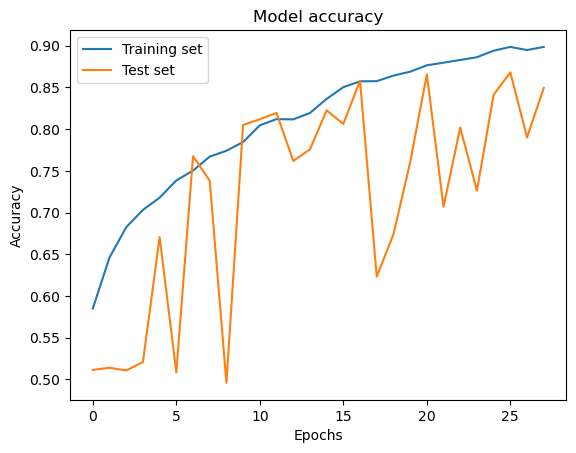

In [150]:
#Resumen del entrenamiento por medio de la asertividad (accuracy)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training set', 'Test set'], loc='best')
plt.show();

In [151]:
train_df['category'].value_counts()

category
fake    3217
real    3183
Name: count, dtype: int64

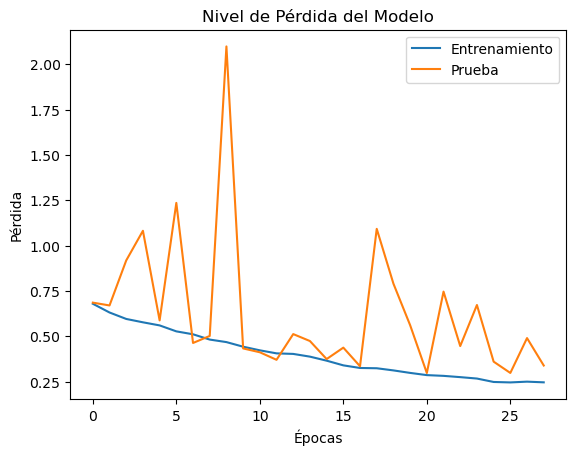

In [152]:
#Resumen del entrenamiento por medio de la pérdida (loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Nivel de Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Prueba'], loc='best')
plt.show();

In [153]:
#Generar un Diccionario con las Categorías de Clasificación de las Imágenes
traingenerator.class_indices
labels = (traingenerator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print("Las categorías de clasificación de las imágenes son:", labels)


Las categorías de clasificación de las imágenes son: {0: 'fake', 1: 'real'}


In [154]:
loss, acc, auc = model.evaluate(testgenerator)
print(f"\n✅ Evaluación final:  \nAccuracy: {acc:.4f} AUC: {auc:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.8689 - auc: 0.9524 - loss: 0.2875

✅ Evaluación final:  
Accuracy: 0.8656 AUC: 0.9499


In [155]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np
    
#def test_the_model(model, image_path):
    # Cargar imagen
#    img = io.imread(image_path)

    # Verificar número de canales
#    if len(img.shape) == 2:  # Imagen en escala de grises
#        img = np.expand_dims(img, axis=-1)  # Añadir canal extra para forma (128,128,1)

    # Redimensionar y normalizar
#    img = resize(img, (128, 128, 1))  # Asegura forma (128,128,1)
#    img = img / 255.0
#    img = np.reshape(img, (1, 128, 128, 1))  # Para el modelo

    # Predicción
#    prediction = model.predict(img)
#    predicted_class = np.argmax(prediction)

    # Obtener etiquetas
#    labels = (traingenerator.class_indices)
#    labels = dict((v, k) for k, v in labels.items())
#    return labels[predicted_class]

def test_the_model(model, img_path):
    img = image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 128, 128, 1)

    prediction = model.predict(img_array, verbose=0)[0][0]

    return 'fake' if prediction < 0.5 else 'real'  # devuelve la clase como string


filename = 'fake_5.png'
predicted = test_the_model(model, f'./dataset_fake_real/{filename}')

real_category = fake_real[fake_real['filename'] == filename]['category'].values[0]
print(f'Prediction: {predicted}')

print(f'True category: {real_category}')


Prediction: fake
True category: fake


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

        fake       0.90      0.82      0.86       783
        real       0.84      0.91      0.87       817

    accuracy                           0.87      1600
   macro avg       0.87      0.86      0.87      1600
weighted avg       0.87      0.87      0.87      1600



<Figure size 600x500 with 0 Axes>

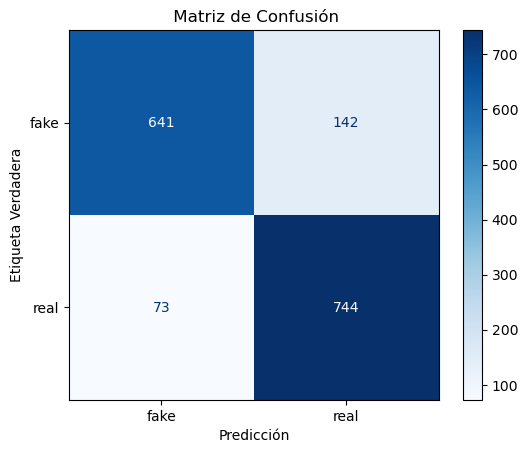

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ============================
#  1. Obtener etiquetas y predicciones
# ============================

# Asegúrate que testgenerator tenga shuffle=False
y_true = testgenerator.classes

# Predicciones del modelo (probabilidades)
y_pred_probs = model.predict(testgenerator, verbose=1)

# Convertir a 0 o 1 según umbral 0.5
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)

# ============================
# 2. Reporte de clasificación
# ============================

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['fake', 'real']))

# ============================
# 3. Matriz de confusión
# ============================

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])

# ============================
#  4. Visualizar la matriz
# ============================

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(" Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.grid(False)
plt.show()
